# Conditional Generative Adversarial Networks
Rather then just generating random samples, we can condition GAN's to some vector z by simply feeding the data, y that we wish to condition on to both the generator and discriminator. Hence, our Generator and Discriminator are now G(z,y) and D(x,y) respectively. Usually, y can be any type of additional inputs, for example, class labels.

We can see it with a probabilistic point of view. G(z,y) is modeling the distribution of our data, given z and y, that is, our data is generated with this scheme x∼G(x|z,y).

Similarly, for the Discriminator, now it tries to find discriminating label for x and xG, that are modeled with d∼D(d|x,y).

Hence, we could see that both D and G is jointly conditioned to two variable z or x and y.

Now, the objective function is given by:

$\min_G \max_D V(D, G) = \mathop{\mathbb{E}}_{x \sim p_{data}(x)} [\log D(x, y)] + \mathop{\mathbb{E}}_{z \sim p_z(z)} [\log(1 – D(G(z, y), y))]$

## AC-GAN
The main difference between the AC-GAN and a vanilla GAN is that to train the AC-GAN we need both training samples and training labels. These training labels are fed into the Generator, that will generate fake images using both the random noise, and the input label. The Discriminator also has to predict the source of the image, and in the AC-GAN scenario, it also has to predict the label of the image. This procedure is quite similar to the traditional Deep Learning method. 

ref: 
* http://cican17.com/gan-from-zero-to-hero-part-2-conditional-generation-by-gan/
* https://arxiv.org/pdf/1610.09585.pdf

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import Input, Reshape, Flatten, multiply
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers
from scipy.interpolate import interp1d

Using TensorFlow backend.


Define class labels

In [2]:
# classes dictionary
label_dict = {0: 'tshirt',
             1: 'trouser',
             2: 'pullover',
             3: 'dress',
             4: 'coat',
             5: 'sandal',
             6: 'shirt',
             7: 'sneaker',
             8: 'bag',
             9: 'boot'}

In [3]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    return (x_train, y_train, x_test, y_test)
 
x_train, y_train, x_test, y_test = load_minst_data()
input_classes =pd.Series(y_train).nunique()
print("x_train shape: {}".format(x_train.shape))
print("y_train.shape:{}".format(y_train.shape))

x_train shape: (60000, 28, 28)
y_train.shape:(60000,)


Define AC Gan class

In [4]:
from __future__ import print_function, division
 
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
 
import matplotlib.pyplot as plt
 
import numpy as np
 
class ACGAN():
    def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100):
        # Input shape
        self.img_rows = input_rows
        self.img_cols = input_cols
        self.channels = input_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = input_classes
        self.latent_dim = latent_dim
 
        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']
 
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])
 
        # Build the generator
        self.generator = self.build_generator()
 
        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
 
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
 
        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)
 
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)
 
    def build_generator(self):
 
        model = Sequential()
 
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))
 
        model.summary()
 
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))
 
        model_input = multiply([noise, label_embedding])
        img = model(model_input)
 
        return Model([noise, label], img)
 
    def build_discriminator(self):
 
        model = Sequential()
 
        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
 
        model.add(Flatten())
        model.summary()
 
        img = Input(shape=self.img_shape)
 
        # Extract feature representation
        features = model(img)
 
        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)
 
        return Model(img, [validity, label])
 
    def train(self, x_train, y_train, epochs, batch_size=128, sample_interval=50):
 
        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()
        #X_train, y_train = self.X_train, self.y_train
 
        # Configure inputs
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        x_train = np.expand_dims(x_train, axis=3)
        y_train = y_train.reshape(-1, 1)
 
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
 
        # Loss output
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))
 
        for epoch in range(epochs):
 
            # ---------------------
            #  Train Discriminator
            # ---------------------
 
            # Select a random batch of images
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]
 
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))
 
            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))
 
            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])
 
            # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)
 
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
 
            # ---------------------
            #  Train Generator
            # ---------------------
 
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])
 
            #show the final losses
            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]
 
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
                #do not save model
                #self.save_model()
                self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)
 
        return g_loss_epochs, d_loss_epochs
 
 
    #row, cols to be sampled
    def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
 
        #plt.figure(figsize=fig_size)
        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("../images/%d.png" % epoch)
        else:
            #plt.figure(figsize=fig_size)
            plt.show()
        plt.close()
 
    def sample_single_image(self, noise, label):
        gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
 
    def save_model(self):
 
        def save(model, model_name):
            model_path = "../saved_model/%s.json" % model_name
            weights_path = "../saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            #
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])
 
        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

Define and train the model

In [5]:
input_rows = 28
input_cols = 28
input_channels = 1
input_classes = len(label_dict)

fahsion_acgan = ACGAN(input_rows, input_cols, input_channels, input_classes)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyR

C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Instructions for updating:
Use tf.cast instead.
Epoch: 0 [D loss: 3.359303, acc.: 34.00%, op_acc: 9.00%] [G loss: 3.297601]


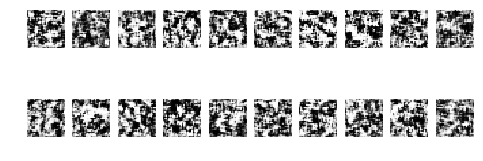

Epoch: 200 [D loss: 1.949783, acc.: 51.50%, op_acc: 47.50%] [G loss: 2.193429]


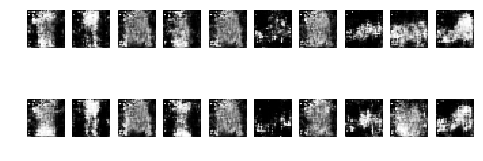

Epoch: 400 [D loss: 1.996836, acc.: 49.00%, op_acc: 39.50%] [G loss: 1.892966]


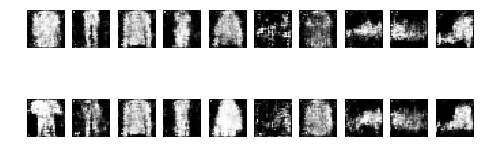

Epoch: 600 [D loss: 1.896753, acc.: 50.50%, op_acc: 45.50%] [G loss: 1.857549]


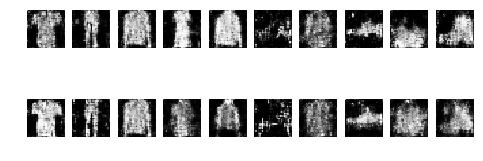

Epoch: 800 [D loss: 1.945723, acc.: 43.50%, op_acc: 38.50%] [G loss: 1.866528]


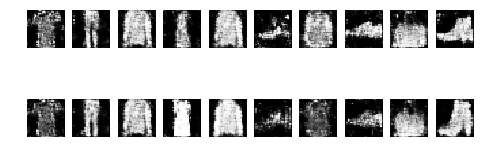

Epoch: 1000 [D loss: 1.859810, acc.: 47.00%, op_acc: 44.00%] [G loss: 1.840368]


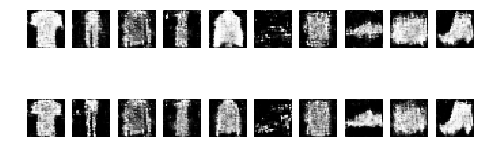

Epoch: 1200 [D loss: 1.884822, acc.: 44.50%, op_acc: 40.00%] [G loss: 1.716180]


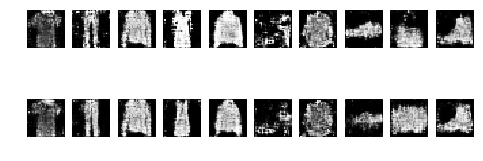

Epoch: 1400 [D loss: 1.774955, acc.: 55.50%, op_acc: 40.50%] [G loss: 1.790140]


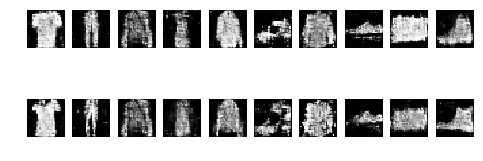

Epoch: 1600 [D loss: 1.769244, acc.: 54.50%, op_acc: 40.50%] [G loss: 1.762519]


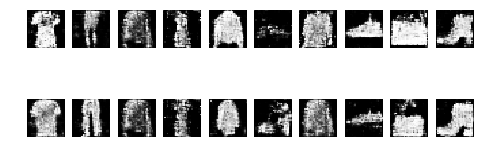

Epoch: 1800 [D loss: 1.797215, acc.: 51.50%, op_acc: 42.50%] [G loss: 1.846394]


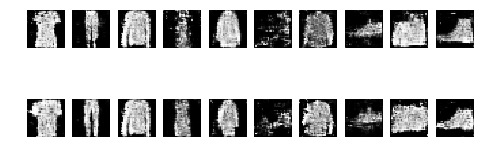

Epoch: 2000 [D loss: 1.773984, acc.: 52.00%, op_acc: 45.00%] [G loss: 1.781837]


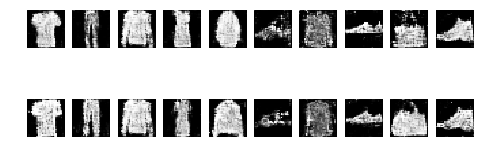

Epoch: 2200 [D loss: 1.772665, acc.: 53.00%, op_acc: 41.00%] [G loss: 1.791299]


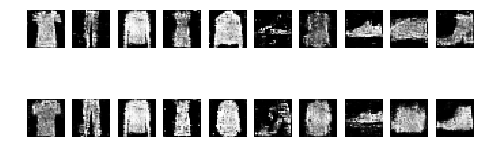

Epoch: 2400 [D loss: 1.686473, acc.: 56.00%, op_acc: 47.00%] [G loss: 1.763907]


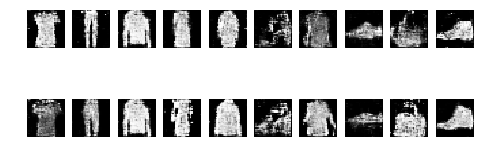

Epoch: 2600 [D loss: 1.706107, acc.: 52.00%, op_acc: 47.50%] [G loss: 1.852525]


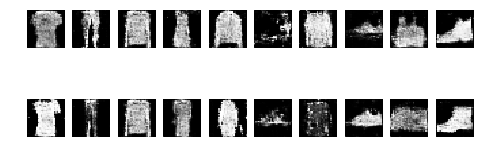

Epoch: 2800 [D loss: 1.684136, acc.: 53.00%, op_acc: 45.00%] [G loss: 1.773884]


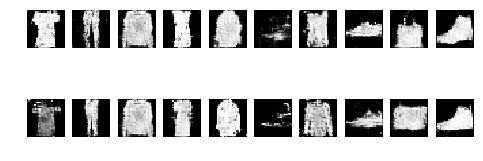

In [6]:
# Train the AC-GAN with the fashion-mnist data
g_loss, d_loss = fahsion_acgan.train(x_train,y_train, epochs=3000, batch_size=100,sample_interval=200)

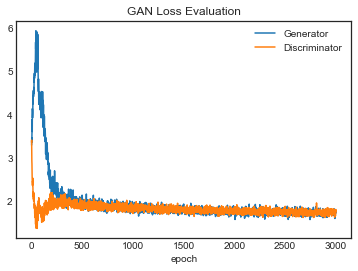

In [7]:
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss Evaluation')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'],loc='upper right')
    plt.show()
 
plt.style.use('seaborn-white')
plot_gan_losses(g_loss, d_loss)